In [389]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import re


### Load the 'business' dataset

In [2]:
df2 = pd.read_json("yelp_academic_dataset_business.json", chunksize = 1000, lines = True)
drop_cols = ['address', 'state', 'postal_code', 'latitude', 'longitude', 'stars', 'review_count', 'is_open','attributes', 'hours']

* Deleting non useful columns

In [3]:
import time
start = time.time()
chunks = []
a = 0
for chunk in df2:
    a += 1
    chunk_b = chunk.drop(drop_cols, axis = 1)
    restas = chunk_b[chunk_b['categories'].str.contains('restaurant', case = False, na = False)]
    chunks.append(restas)
restaurants = pd.concat(chunks, ignore_index= True, join='outer')
end = time.time()
elapsed = end-start

In [4]:
restaurants.shape

(63961, 4)

## Load the reviews dataset
* Remember we made the merge to use ONLY restaurants data, because there were data from other things

In [5]:
reviews_raw = pd.read_json("yelp_academic_dataset_review.json", chunksize=100000, lines = True)
drop_cols = ['review_id', 'user_id','useful', 'funny', 'cool', 'date']

* Using merge instead of join because we want to join in another column other than the index

In [6]:
a = 0
for chunk in reviews_raw:
    a += 1
    reviews = chunk.drop(drop_cols, axis = 1)
    data = restaurants.merge(reviews, left_on = 'business_id', right_on = 'business_id',how = 'inner')
    if a == 1:
        break

### Finally the data to be preprocessed (the "text" column, to be exact) 
TBD:
* Delete all number 3 i.e neutral 
* Same number of positive as negatives
* Shuffle the data

In [7]:
data.head()

,business_id,name,city,categories,stars,text
0,pQeaRpvuhoEqudo3uymHIQ,The Empanadas House,Champaign,"Ethnic Food, Food Trucks, Specialty Food, Impo...",5,I love the empanadas from the Empanadas House!...
1,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,"Food, Restaurants, Grocery, Middle Eastern",3,"Definitely under new management, and the dinin..."
2,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,Charlotte,"Food, Restaurants, Grocery, Middle Eastern",3,I will also agree that this place has great fo...
3,lu7vtrp_bE9PnxWfA8g4Pg,Banzai Sushi,Thornhill,"Japanese, Fast Food, Food Court, Restaurants",4,Been coming here since I was in grade 9 so abo...
4,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,Phoenix,"Food, Pretzels, Bakeries, Fast Food, Restaurants",5,Love Wetzel's pretzels! I always get them when...


## Get a toyset to work in trials from here

In [91]:
data2 = data.loc[0:99, ['name', 'stars', 'text']]
data2.head()

,name,stars,text
0,The Empanadas House,5,I love the empanadas from the Empanadas House!...
1,Middle East Deli,3,"Definitely under new management, and the dinin..."
2,Middle East Deli,3,I will also agree that this place has great fo...
3,Banzai Sushi,4,Been coming here since I was in grade 9 so abo...
4,Wetzel's Pretzels,5,Love Wetzel's pretzels! I always get them when...


* Some graphs to know the number of reviews by ranking

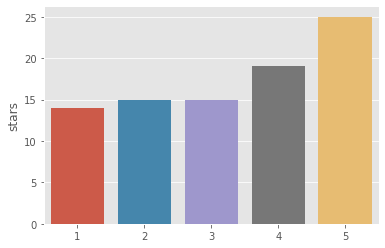

In [143]:
bars = data3['stars'].value_counts()
sns.barplot(x = bars.index, y = bars)

* Delete the number 3's

In [90]:
data2.drop(data2[data2['stars'] == 3].index, inplace = True)
data2 = data2.reset_index(drop = True)
data2

(85, 3)

* We want just the reviews with 4-5 to be positive and the 1-2 to be negative, we do that on the following

In [11]:
data2['Sentiment'] = data2['stars'].apply(lambda x: 1 if x > 3 else 0)

### Use "3" as negative to augment the data and  balance the classes
One could argue that the reviews that have not unconditionally positive

In [146]:
data3 = data2.copy()
neg_half = list((data3[data3['stars'] <=3]).index)
pos_half = list(set(range(data3.shape[0])) - set(neg_half))
pos_half = pos_half[0:len(neg_half)]
pos_half.extend(neg_half)
dropper = list(set(range(data3.shape[0])) - set(pos_half))
data3.drop(index = dropper, inplace = True)
data3['Sentiment'] = data3['stars'].apply(lambda x: 1 if x > 3 else 0)

In [148]:
data3['Sentiment'].value_counts()
data2 = data3.copy()

## From here start the NLP pipeline

The goal here is to make a bag of words, it can be done manually, but also with sklearn.

**Steps:** I am trying to extract the nest tokens with the tokenizer from Potts and then feed that already "clean tokens" to the vectorizer

In [149]:
raw = data2['text'][1:3]
raw
raw2 = data2['text'][1]

In [150]:
from nltk.probability import FreqDist
counter = FreqDist()

In [151]:
tokenizer = []
a = 0
for i in raw2:
    words = i.lower()
    words = words.split()
    for word in words:
        a += 1
        counter[word] += 1
        if word not in tokenizer:
            tokenizer.append(word)
len(tokenizer)
tokenizer
words = raw2.split()
for word in words:
    a += 1
len(words)

98

### For the negation tagging, put the negation until ^[.:;!?]$ (until the punctuation mark)

In [152]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [153]:
#out of the box tokenizer and counter
from nltk.probability import FreqDist
counter = FreqDist()
tokens_nltk = word_tokenize(raw2)

tokenizer = []
for word in tokens_nltk:
    counter[word.lower()] += 1

len(tokens_nltk)
len(counter)
counter['the']

5

In [154]:
counter.B() #is the number of unique words (?)
x = counter.N #is the number of words
counter.most_common(20)

[(',', 12),
 ('.', 6),
 ('and', 5),
 ('the', 5),
 ('has', 4),
 ('a', 3),
 ('that', 3),
 ("'s", 2),
 ('some', 2),
 ('have', 2),
 ('on', 2),
 ('definitely', 1),
 ('under', 1),
 ('new', 1),
 ('management', 1),
 ('dining', 1),
 ('area', 1),
 ('been', 1),
 ('totally', 1),
 ('redone', 1)]

In [155]:
stop = set(stopwords.words("english"))

TBD:
### Check the paper that is mentioned in notion by UCLondon

* Delete all the reviews that are not in english
* Same number of negative that as positive reviews for the sets
* Tokenization and BoW creation (**BoW with frequency or with presence?**)
* unigrams and bigrams
* lower the case
* POS tagging?
* EDA como en potts con las palabras mas frecuentes en positives and negatives reviews
* Handling negation? _NOT or with sentiment negative scoring?
* See the book by Bing Lui for how to identify fake news, resonates with anomaly detection and identifying if a review is fake

In [156]:
string = """Hello my Number is 123456789 and  
             my friend's number is 987654321, and my number is also 987654321"""
    
# A sample regular expression to find digits.  
regex = '\d+'             
    
match = re.findall(regex, string)  
print(match)
raw2

['123456789', '987654321', '987654321']


"Definitely under new management, and the dining area has been totally redone. Big, comfy chairs, dangling bistro lighting, it's somewhat comfier.\n\nThe menu has changed quite a bit - this learns more towards Turkish than anything else, and has some interesting options for you meaters. Veg fare hasn't budged, and neither have the prices, but the quality and portion size have improved some. Falafel now comes with a smidge of hummus on the side, which is a nice touch.\n\nEveryone that waited on me was very tall, female, and beautiful, in that awesome Mediterranean way, so there's that."

## Negation tagging Function

In [157]:
def pesimist(text):
    x = text
    x = x.split()
    hasta = 0
    desde = 0
    c = 0
    j = 0
    passer = False
    for k in range(len(x)):
        #print(j)
        #print(k)
        #if not passer:
            #continue
        passer = True

        i = x[k]
        negation_string = r"""
        ^(?:never|no|nothing|nowhere|noone|none|not|
            havent|hasnt|hadnt|cant|couldnt|shouldnt|
            wont|wouldnt|but|doesnt|didnt|isnt|arent|aint
        )$|n't
        """
        #print("first")
        c +=1
        #match = re.search(r'\bthe\b',i)
        neg = re.compile(negation_string, re.VERBOSE | re.I | re.UNICODE)
        match = neg.findall(i)
        #print(i + "i")
        #print('desde', desde)
        #print(f'hasta menos desde es: {hasta - desde} y c es {c}')
        if c < (hasta - desde):
            continue
        if match:
            c = 0
            desde = k + 1
            #print(c - 1)
            #j = i
            jump = k
            for j in range(jump, 100):

                #print(j)
                try:
                    comma = re.search(r'[.:;!?]', x[j])
                    #print("second")
                    if comma:
                        hasta = j + 1
                        c += 1
                        
                        #this try to avoid error if there is no punctuation error before the phrase ends
                        try:
                            for i in range(desde, hasta):
                                repl = re.match(r'\w+', x[i])
                                x[i] = repl.group() + "_NOT"
                            
                            c = 0
                            break
                        except:
                            #print(' '.join(x))
                            c = 0
                            break
                except:
                    pass
        if match:
            continue



                #continue


            #else:
                #continue
            #break
    xx = ' '.join(x)
    return xx

## Finally the negation tagging is working, next steps:
    1. Identify all the negation words on the regular expresion, can be taken from one paper.
    2. Implement it i conjuction with the tokenizer and the stop words removal
    3. run it for all the dataset
    4. Balance the positive and negative classes on the data set that we are going to take to make all the trials.
    5. Finish the identification of features
    6. 

## Current status

order of the pipeline (in **bold** what is already done)

(balance the sample 50/50 in reviews)
1. **Negator**
2. **Tokenizer**
3. Stop words removal (kind of done, have to figure it out)
3. BoW


## Negation tagging

In [158]:
trial = data2.copy()

In [159]:
#Apply the function of negation taggin to each row
trial["sample"] = trial.loc[:, "text"].apply(pesimist)

In [160]:
trial.head()

,name,stars,text,Sentiment,sample
0,The Empanadas House,5,I love the empanadas from the Empanadas House!...,1,I love the empanadas from the Empanadas House!...
1,Middle East Deli,3,"Definitely under new management, and the dinin...",0,"Definitely under new management, and the dinin..."
2,Middle East Deli,3,I will also agree that this place has great fo...,0,I will also agree that this place has great fo...
3,Banzai Sushi,4,Been coming here since I was in grade 9 so abo...,1,Been coming here since I was in grade 9 so abo...
4,Wetzel's Pretzels,5,Love Wetzel's pretzels! I always get them when...,1,Love Wetzel's pretzels! I always get them when...


## Tokenizer


In [161]:
from Utils.happyfuntokenizing import Tokenizer

In [162]:
tok = Tokenizer()

In [163]:
token = tok.tokenize(raw2)

In [164]:
token

['definitely',
 'under',
 'new',
 'management',
 'and',
 'the',
 'dining',
 'area',
 'has',
 'been',
 'totally',
 'redone',
 'big',
 'comfy',
 'chairs',
 'dangling',
 'bistro',
 'lighting',
 "it's",
 'somewhat',
 'comfier',
 'the',
 'menu',
 'has',
 'changed',
 'quite',
 'a',
 'bit',
 'this',
 'learns',
 'more',
 'towards',
 'turkish',
 'than',
 'anything',
 'else',
 'and',
 'has',
 'some',
 'interesting',
 'options',
 'for',
 'you',
 'meaters',
 'veg',
 'fare',
 "hasn't",
 'budged',
 'and',
 'neither',
 'have',
 'the',
 'prices',
 'but',
 'the',
 'quality',
 'and',
 'portion',
 'size',
 'have',
 'improved',
 'some',
 'falafel',
 'now',
 'comes',
 'with',
 'a',
 'smidge',
 'of',
 'hummus',
 'on',
 'the',
 'side',
 'which',
 'is',
 'a',
 'nice',
 'touch',
 'everyone',
 'that',
 'waited',
 'on',
 'me',
 'was',
 'very',
 'tall',
 'female',
 'and',
 'beautiful',
 'in',
 'that',
 'awesome',
 'mediterranean',
 'way',
 'so',
 "there's",
 'that']

In [331]:
tok = Tokenizer()
tok.__dict__

{'preserve_case': False, 'all_in': False}

In [342]:
trial["tokens"] = trial.loc[:, "sample"].apply(tok.tokenize)
trial.reset_index(inplace = True)

In [339]:
trial["Sentiment"].value_counts()

1    44
0    44
Name: Sentiment, dtype: int64

In [343]:
trial

,index,name,stars,text,Sentiment,sample,tokens
0,0,The Empanadas House,5,I love the empanadas from the Empanadas House!...,1,I love the empanadas from the Empanadas House!...,"[i, love, the, empanadas, from, the, empanadas..."
1,1,Middle East Deli,3,"Definitely under new management, and the dinin...",0,"Definitely under new management, and the dinin...","[definitely, under, new, management, and, the,..."
2,2,Middle East Deli,3,I will also agree that this place has great fo...,0,I will also agree that this place has great fo...,"[i, will, also, agree, that, this, place, has,..."
3,3,Banzai Sushi,4,Been coming here since I was in grade 9 so abo...,1,Been coming here since I was in grade 9 so abo...,"[been, coming, here, since, i, was, in, grade,..."
4,4,Wetzel's Pretzels,5,Love Wetzel's pretzels! I always get them when...,1,Love Wetzel's pretzels! I always get them when...,"[love, wetzel's, pretzels, i, always, get, the..."
...,...,...,...,...,...,...,...
83,91,Papaya Thai,1,Used a Groupon today to eat here and they gave...,0,Used a Groupon today to eat here and they gave...,"[used, a, groupon, today, to, eat, here, and, ..."
84,92,Papaya Thai,3,"Ordered the samurai pad tie,vegetable tempura,...",0,"Ordered the samurai pad tie,vegetable tempura,...","[ordered, the, samurai, pad, tie, vegetable, t..."
85,94,Papaya Thai,1,"The owner, ""V"", does not pay employees on time...",0,"The owner, ""V"", does not pay_NOT employees_NOT...","[the, owner, v, does, not, pay_not, employees_..."
86,95,Papaya Thai,2,"I would give this 3 stars, but I really couldn...",0,"I would give this 3 stars, but I_NOT really_NO...","[i, would, give, this, 3, stars, but, i_not, r..."


## Bag of words
Using the tokens, of course
* Make the corpora
* Make the vectors with word presence/frecuency. I think presenc may be better for vector-space representation

In [345]:
corpora = trial['tokens'].to_numpy()

In [227]:
def corpus_builder(corpora):
    main_corpus = []
    for review in corpora:
        for word in review:
            if word not in main_corpus:
                main_corpus.append(word)
    return main_corpus

In [391]:
def counter(bow, vector):
    counter = dict.fromkeys(bow, 0)
    for word in vector:
        if word not in bow and word not in counter.keys():
            counter[word] = 0
            
            counter[word] += 1
    return list(counter.values())
cc = counter(bow, xx)
cc2 = counter(bow, xx)
cc

/Users/Rafa/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  after removing the cwd from sys.path.


TypeError: unhashable type: 'numpy.ndarray'

In [386]:
bow = corpus_builder(corpora)
def vectorizer(review_series):
    """
    review_series : pandas object (series)  i.e dataframe[name_of_column]
    """
    X = []
    i = 0
    for review in review_series:
        word_vector = counter(bow, review)
        if i < 1:
            X = np.array([word_vector])
            print(X.shape())
            i += 1
        X = np.append(X, [word_vector], axis = 0)
    return X

In [380]:
corpora = trial['tokens']
X =vectorizer(corpora)


TypeError: 'tuple' object is not callable

In [359]:
for review in corpora:
    print(review)
    print(" ")

['i', 'love', 'the', 'empanadas', 'from', 'the', 'empanadas', 'house', "they're", 'authentic', 'argentine', 'empanadas', 'and', 'they', 'are', 'delicious', 'if', 'you', 'have', 'a', 'sweet', 'tooth', 'try', 'the', 'dulce', 'de', 'leche', 'with', 'walnuts']
 
['definitely', 'under', 'new', 'management', 'and', 'the', 'dining', 'area', 'has', 'been', 'totally', 'redone', 'big', 'comfy', 'chairs', 'dangling', 'bistro', 'lighting', "it's", 'somewhat', 'comfier', 'the', 'menu', 'has', 'changed', 'quite', 'a', 'bit', 'this', 'learns', 'more', 'towards', 'turkish', 'than', 'anything', 'else', 'and', 'has', 'some', 'interesting', 'options', 'for', 'you', 'meaters', 'veg', 'fare', "hasn't", 'budged_not', 'and_not', 'neither_not', 'have_not', 'the_not', 'prices_not', 'but_not', 'the_not', 'quality_not', 'and_not', 'portion_not', 'size_not', 'have_not', 'improved_not', 'some_not', 'falafel', 'now', 'comes', 'with', 'a', 'smidge', 'of', 'hummus', 'on', 'the', 'side', 'which', 'is', 'a', 'nice', 't